# ABM 1


In [ ]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random

# --- Initial State ---
initial_state = {
    'mempool': [],  # List of pending transactions
    'ledger': [],   # List of confirmed blocks
    'energy_used': 0,  # Total energy in GJ
    'synced_nodes': 0,  # Number of nodes synced per step
    'agents': {
        'miners': [{'id': i, 'compute_power': random.uniform(5.0, 10.0), 'wallet': 0} for i in range(10)],
        'nodes': [{'id': i} for i in range(20)],
        'users': [{'id': i, 'type': random.choice(['P2P', 'Investor', 'Trader'])} for i in range(50)]
    }
}

# --- State Update Functions ---
def update_mempool(params, step, sL, s, _input):
    mempool = s['mempool'].copy()
    new_txs = _input.get('new_transactions', [])
    mined_txs = _input.get('mined_transactions', [])
    # Remove mined transactions from mempool
    for tx in mined_txs:
        if tx in mempool:
            mempool.remove(tx)
    mempool.extend(new_txs)
    return ('mempool', mempool)

def update_ledger(params, step, sL, s, _input):
    ledger = s['ledger'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        ledger.extend(mined_txs)  # Add individual transactions to ledger
    return ('ledger', ledger)

def update_energy(params, step, sL, s, _input):
    energy = s['energy_used']
    energy_increment = _input.get('energy_increment', 0)
    return ('energy_used', energy + energy_increment)

def update_synced_nodes(params, step, sL, s, _input):
    synced = _input.get('synced_nodes', 0)
    return ('synced_nodes', synced)

def update_agents(params, step, sL, s, _input):
    agents = s['agents'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        for miner in agents['miners']:
            if random.random() < 0.1:  # Arbitrary miner selection for reward
                miner['wallet'] += 6.25  # Block reward
    return ('agents', agents)

# --- Policy Functions ---
def user_policy(params, step, sL, s):
    agents = s['agents']
    new_txs = []
    tx_rates = {'P2P': 0.5, 'Investor': 0.2, 'Trader': 0.7}
    for user in agents['users']:
        if random.random() < tx_rates[user['type']]:
            size = {'P2P': 480, 'Investor': 1000, 'Trader': 720}[user['type']]  # bytes
            fee_rate = random.uniform(50, 200)  # satoshis/vbyte
            new_txs.append({'size': size, 'fee_rate': fee_rate})
    return {'new_transactions': new_txs}

def miner_policy(params, step, sL, s):
    agents = s['agents']
    mempool = s['mempool'].copy()
    mined_txs = []
    energy_increment = 0
    if mempool:
        for miner in agents['miners']:
            if random.random() < miner['compute_power'] / 15:  # Even easier PoW (div by 15)
                tx = max(mempool, key=lambda x: x['fee_rate'])
                mined_txs.append(tx)
                energy_increment += 0.1 * 1e9  # 0.1 J/hash, 1 TH = 1e9 hashes
    return {'mined_transactions': mined_txs, 'energy_increment': energy_increment}

def node_policy(params, step, sL, s):
    agents = s['agents']
    ledger = s['ledger']
    synced_nodes = 0
    for node in agents['nodes']:
        if ledger and random.random() < 0.9:  # 90% sync chance
            synced_nodes += 1
    return {'synced_nodes': synced_nodes}

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {'policies': {'p1': user_policy}, 'variables': {'mempool': update_mempool}},
    {'policies': {'p1': miner_policy}, 'variables': {
        'mempool': update_mempool,
        'ledger': update_ledger,
        'energy_used': update_energy,
        'agents': update_agents
    }},
    {'policies': {'p1': node_policy}, 'variables': {'synced_nodes': update_synced_nodes}}
]

# --- Parameters ---
params = {
    'dummy': 1
}

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),  # 40 steps = 10 minutes at 15s/step
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
# Filter for the last substep of each timestep
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep'].values  # Ensure correct timestep range (0-39)
mempool_sizes = final_substep['mempool'].apply(lambda x: sum(tx['size'] for tx in x) / 1e6 if x else 0).values  # MB
ledger_sizes = final_substep['ledger'].apply(lambda x: len(x) if x else 0).values  # Count transactions in ledger
energy_used = final_substep['energy_used'].values / 1e9  # GJ

# Debug: Print intermediate values to confirm data
print("Timesteps:", timesteps)
print("Mempool Sizes (MB):", mempool_sizes)
print("Ledger Sizes (Blocks):", ledger_sizes)

# Plot with three subplots: mempool, blocks, energy
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
ax1.set_title("Mempool Size (MB)")
ax2.set_title("Blocks Confirmed")
ax3.set_title("Energy Used (GJ)")

# Set x-axis to timesteps
ax1.set_xlim(0, 40)
ax2.set_xlim(0, 40)
ax3.set_xlim(0, 40)

# Set y-limits
ax1.set_ylim(0, max(mempool_sizes, default=1) * 1.5)
ax2.set_ylim(0, max(ledger_sizes, default=1) * 1.5)
ax3.set_ylim(0, max(energy_used, default=1) * 1.5)

# Labels
ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Mempool Size (MB)")
ax2.set_ylabel("Blocks Confirmed")
ax3.set_ylabel("Energy Used (GJ)")

line1, = ax1.plot([], [], 'b-', label="Mempool Size")
line2, = ax2.plot([], [], 'g-', label="Blocks")
line3, = ax3.plot([], [], 'r-', label="Energy")
ax1.legend()
ax2.legend()
ax3.legend()

def update(frame):
    line1.set_data(timesteps[:frame + 1], mempool_sizes[:frame + 1])
    line2.set_data(timesteps[:frame + 1], ledger_sizes[:frame + 1])
    line3.set_data(timesteps[:frame + 1], energy_used[:frame + 1])
    return line1, line2, line3

ani = FuncAnimation(fig, update, frames=len(timesteps), interval=200, blit=True)
plt.tight_layout()
ani.save("bitcoin_abm.mp4", writer="ffmpeg")
HTML('<video controls src="bitcoin_abm.mp4" />')

# Metrics
throughput = ledger_sizes[-1] / (40 * 15 / 3600)  # tx/hour
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_sizes[-1]:.2f} MB")
print(f"Energy Used: {energy_used[-1]:.2f} GJ")

# ABM 2

In [ ]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random

# --- Initial State ---
initial_state = {
    'mempool': [],  # List of pending transactions
    'ledger': [],   # List of confirmed blocks
    'energy_used': 0,  # Total energy in GJ
    'synced_nodes': 0,  # Number of nodes synced per step
    'agents': {
        'miners': [{'id': i, 'compute_power': random.uniform(5.0, 10.0), 'wallet': 0} for i in range(10)],
        'nodes': [{'id': i} for i in range(20)],
        'users': [{'id': i, 'type': random.choice(['P2P', 'Investor', 'Trader'])} for i in range(50)]
    }
}

# --- State Update Functions ---
def update_mempool(params, step, sL, s, _input):
    mempool = s['mempool'].copy()
    new_txs = _input.get('new_transactions', [])
    mined_txs = _input.get('mined_transactions', [])
    for tx in mined_txs:
        if tx in mempool:
            mempool.remove(tx)
    mempool.extend(new_txs)
    return ('mempool', mempool)

def update_ledger(params, step, sL, s, _input):
    ledger = s['ledger'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        ledger.extend(mined_txs)
    return ('ledger', ledger)

def update_energy(params, step, sL, s, _input):
    energy = s['energy_used']
    energy_increment = _input.get('energy_increment', 0)
    return ('energy_used', energy + energy_increment)

def update_synced_nodes(params, step, sL, s, _input):
    synced = _input.get('synced_nodes', 0)
    return ('synced_nodes', synced)

def update_agents(params, step, sL, s, _input):
    agents = s['agents'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        for miner in agents['miners']:
            if random.random() < 0.1:
                miner['wallet'] += 6.25
    return ('agents', agents)

# --- Policy Functions ---
def user_policy(params, step, sL, s):
    agents = s['agents']
    new_txs = []
    tx_rates = {'P2P': 0.5, 'Investor': 0.2, 'Trader': 0.7}
    for user in agents['users']:
        if random.random() < tx_rates[user['type']]:
            size = {'P2P': 480, 'Investor': 1000, 'Trader': 720}[user['type']]
            fee_rate = random.uniform(50, 200)
            new_txs.append({'size': size, 'fee_rate': fee_rate})
    return {'new_transactions': new_txs}

def miner_policy(params, step, sL, s):
    agents = s['agents']
    mempool = s['mempool'].copy()
    mined_txs = []
    energy_increment = 0
    if mempool:
        for miner in agents['miners']:
            if random.random() < miner['compute_power'] / 30:  # Harder PoW for ~6-10 blocks
                tx = max(mempool, key=lambda x: x['fee_rate'])
                mined_txs.append(tx)
                energy_increment += 0.1 * 1e9
    return {'mined_transactions': mined_txs, 'energy_increment': energy_increment}

def node_policy(params, step, sL, s):
    agents = s['agents']
    ledger = s['ledger']
    synced_nodes = 0
    for node in agents['nodes']:
        if ledger and random.random() < 0.9:
            synced_nodes += 1
    return {'synced_nodes': synced_nodes}

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {'policies': {'p1': user_policy}, 'variables': {'mempool': update_mempool}},
    {'policies': {'p1': miner_policy}, 'variables': {
        'mempool': update_mempool,
        'ledger': update_ledger,
        'energy_used': update_energy,
        'agents': update_agents
    }},
    {'policies': {'p1': node_policy}, 'variables': {'synced_nodes': update_synced_nodes}}
]

# --- Parameters ---
params = {
    'dummy': 1
}

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep'].values
mempool_sizes = final_substep['mempool'].apply(lambda x: sum(tx['size'] for tx in x) / 1e6 if x else 0).values
ledger_sizes = final_substep['ledger'].apply(lambda x: len(x) if x else 0).values
energy_used = final_substep['energy_used'].values / 1e9

# Debug prints
print("Timesteps:", timesteps)
print("Mempool Sizes (MB):", mempool_sizes)
print("Ledger Sizes (Blocks):", ledger_sizes)

# Plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Bitcoin Network Simulation', fontsize=16)

ax1.set_title("Mempool Size (MB)")
ax2.set_title("Blocks Confirmed")
ax3.set_title("Energy Used (GJ)")

ax1.set_xlim(0, 40)
ax2.set_xlim(0, 40)
ax3.set_xlim(0, 40)

ax1.set_ylim(0, max(mempool_sizes, default=1) * 1.5)
ax2.set_ylim(0, max(ledger_sizes, default=1) * 1.5)
ax3.set_ylim(0, max(energy_used, default=1) * 1.5)

ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Mempool Size (MB)")
ax2.set_ylabel("Blocks Confirmed")
ax3.set_ylabel("Energy Used (GJ)")

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

line1, = ax1.plot([], [], 'b-', label="Mempool Size")
line2, = ax2.plot([], [], 'g-', label="Blocks")
line3, = ax3.plot([], [], 'r-', label="Energy")
ax1.legend()
ax2.legend()
ax3.legend()

def update(frame):
    line1.set_data(timesteps[:frame + 1], mempool_sizes[:frame + 1])
    line2.set_data(timesteps[:frame + 1], ledger_sizes[:frame + 1])
    line3.set_data(timesteps[:frame + 1], energy_used[:frame + 1])
    return line1, line2, line3

ani = FuncAnimation(fig, update, frames=len(timesteps), interval=200, blit=True)
plt.tight_layout()
ani.save("bitcoin_abm.mp4", writer="ffmpeg")
HTML('<video controls src="bitcoin_abm.mp4" />')

# Metrics
throughput = ledger_sizes[-1] / (40 * 15 / 3600)
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_sizes[-1]:.2f} MB")
print(f"Energy Used: {energy_used[-1]:.2f} GJ")

# ABM 3

In [ ]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random

# --- Initial State ---
initial_state = {
    'mempool': [],
    'ledger': [],
    'energy_used': 0,
    'synced_nodes': 0,
    'agents': {
        'miners': [{'id': i, 'compute_power': random.uniform(5.0, 10.0), 'wallet': 0} for i in range(10)],
        'nodes': [{'id': i} for i in range(20)],
        'users': [{'id': i, 'type': random.choice(['P2P', 'Investor', 'Trader'])} for i in range(50)]
    }
}

# --- State Update Functions ---
def update_mempool(params, step, sL, s, _input):
    mempool = s['mempool'].copy()
    new_txs = _input.get('new_transactions', [])
    mined_txs = _input.get('mined_transactions', [])
    for tx in mined_txs:
        if tx in mempool:
            mempool.remove(tx)
    mempool.extend(new_txs)
    return ('mempool', mempool)

def update_ledger(params, step, sL, s, _input):
    ledger = s['ledger'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        ledger.extend(mined_txs)
    return ('ledger', ledger)

def update_energy(params, step, sL, s, _input):
    energy = s['energy_used']
    energy_increment = _input.get('energy_increment', 0)
    return ('energy_used', energy + energy_increment)

def update_synced_nodes(params, step, sL, s, _input):
    synced = _input.get('synced_nodes', 0)
    return ('synced_nodes', synced)

def update_agents(params, step, sL, s, _input):
    agents = s['agents'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        for miner in agents['miners']:
            if random.random() < 0.1:
                miner['wallet'] += 6.25
    return ('agents', agents)

# --- Policy Functions ---
def user_policy(params, step, sL, s):
    agents = s['agents']
    new_txs = []
    tx_rates = {'P2P': 0.5, 'Investor': 0.2, 'Trader': 0.7}
    for user in agents['users']:
        if random.random() < tx_rates[user['type']]:
            size = {'P2P': 480, 'Investor': 1000, 'Trader': 720}[user['type']]
            fee_rate = random.uniform(50, 200)
            new_txs.append({'size': size, 'fee_rate': fee_rate})
    return {'new_transactions': new_txs}

def miner_policy(params, step, sL, s):
    agents = s['agents']
    mempool = s['mempool'].copy()
    mined_txs = []
    energy_increment = 0
    if mempool:
        for miner in agents['miners']:
            if random.random() < miner['compute_power'] / 40:  # Harder PoW for ~6-8 blocks
                tx = max(mempool, key=lambda x: x['fee_rate'])
                mined_txs.append(tx)
                energy_increment += 0.1 * 1e9
    return {'mined_transactions': mined_txs, 'energy_increment': energy_increment}

def node_policy(params, step, sL, s):
    agents = s['agents']
    ledger = s['ledger']
    synced_nodes = 0
    for node in agents['nodes']:
        if ledger and random.random() < 0.9:
            synced_nodes += 1
    return {'synced_nodes': synced_nodes}

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {'policies': {'p1': user_policy}, 'variables': {'mempool': update_mempool}},
    {'policies': {'p1': miner_policy}, 'variables': {
        'mempool': update_mempool,
        'ledger': update_ledger,
        'energy_used': update_energy,
        'agents': update_agents
    }},
    {'policies': {'p1': node_policy}, 'variables': {'synced_nodes': update_synced_nodes}}
]

# --- Parameters ---
params = {
    'dummy': 1
}

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep'].values
mempool_sizes = final_substep['mempool'].apply(lambda x: sum(tx['size'] for tx in x) / 1e6 if x else 0).values
ledger_sizes = final_substep['ledger'].apply(lambda x: len(x) if x else 0).values
energy_used = final_substep['energy_used'].values / 1e9

# Debug prints
print("Timesteps:", timesteps)
print("Mempool Sizes (MB):", mempool_sizes)
print("Ledger Sizes (Blocks):", ledger_sizes)

# Plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Bitcoin Network Simulation (10 Min, 10 Miners, 20 Nodes, 50 Users)', fontsize=16)

ax1.set_title("Mempool Size (MB)")
ax2.set_title("Blocks Confirmed")
ax3.set_title("Energy Used (GJ)")

ax1.set_xlim(0, 40)
ax2.set_xlim(0, 40)
ax3.set_xlim(0, 40)

ax1.set_ylim(0, max(mempool_sizes, default=1) * 1.5)
ax2.set_ylim(0, max(ledger_sizes, default=1) * 1.5)
ax3.set_ylim(0, 15)  # Increased to avoid cutting off

ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Mempool Size (MB)")
ax2.set_ylabel("Blocks Confirmed")
ax3.set_ylabel("Energy Used (GJ)")

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

line1, = ax1.plot([], [], 'b-', label="Mempool Size")
line2, = ax2.plot([], [], 'g-', label="Blocks")
line3, = ax3.plot([], [], 'r-', label="Energy")
ax1.legend()
ax2.legend()
ax3.legend()

def update(frame):
    line1.set_data(timesteps[:frame + 1], mempool_sizes[:frame + 1])
    line2.set_data(timesteps[:frame + 1], ledger_sizes[:frame + 1])
    line3.set_data(timesteps[:frame + 1], energy_used[:frame + 1])
    return line1, line2, line3

ani = FuncAnimation(fig, update, frames=len(timesteps), interval=200, blit=True)
plt.tight_layout()
ani.save("bitcoin_abm.mp4", writer="ffmpeg")
HTML('<video controls src="bitcoin_abm.mp4" />')

# Metrics
throughput = ledger_sizes[-1] / (40 * 15 / 3600)
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_sizes[-1]:.2f} MB")
print(f"Energy Used: {energy_used[-1]:.2f} GJ")

# ABM 4



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 40, 3, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (40, 3, 1, 5)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/121 [00:00<?, ?it/s]

Total execution time: 0.29s


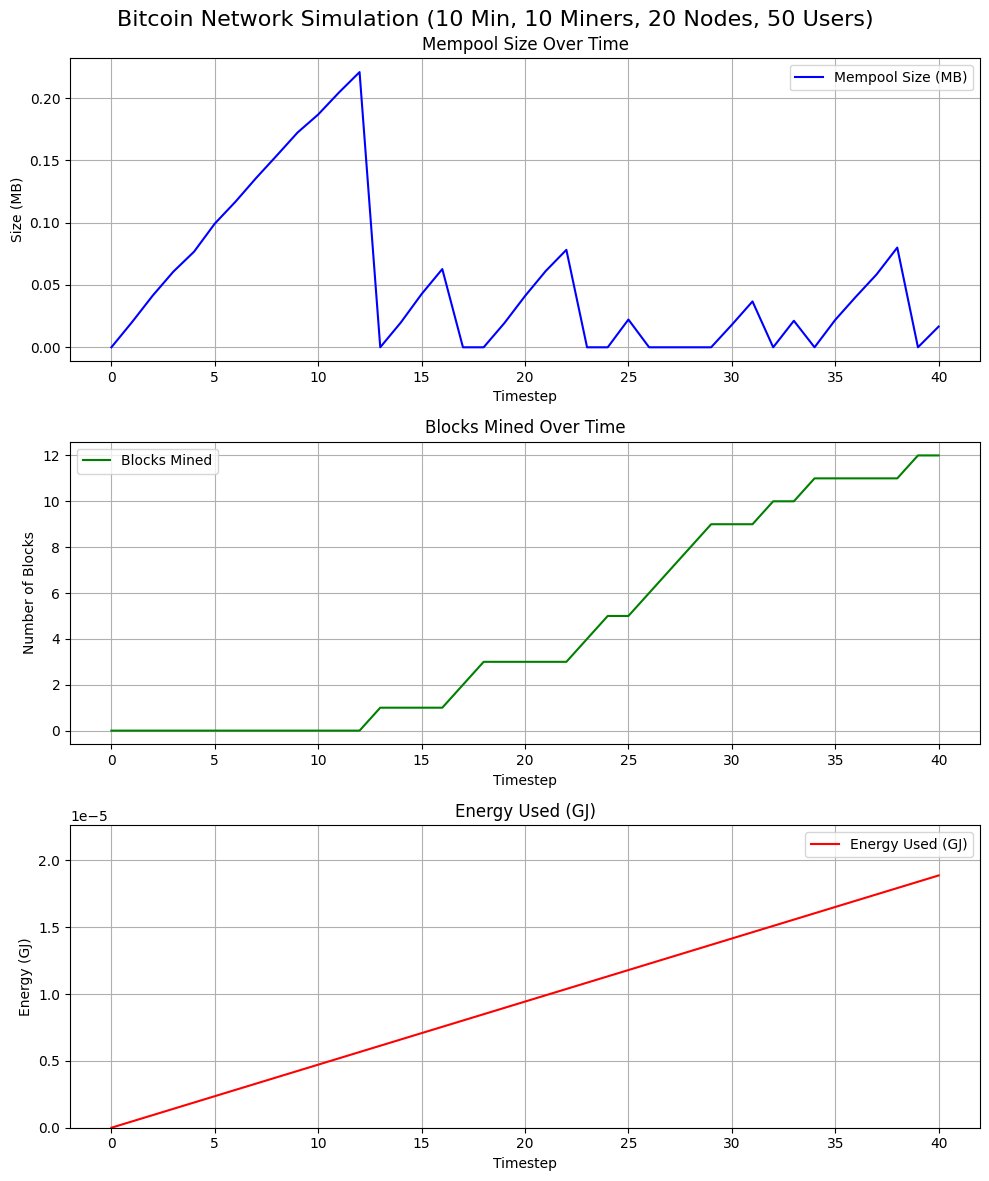

Total blocks mined: 12
Total transactions processed: 1073
Average transactions per block: 89.42
Transaction Throughput: 6438.00 tx/hour
Final Mempool Size: 0.02 MB
Energy Used: 0.00 GJ


In [ ]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
import json

# --- Initial State ---
initial_state = {
    'mempool': [],
    'ledger': [],
    'energy_used': 0,
    'synced_nodes': 0,
    'agents': {
        'miners': [{'id': i, 'compute_power': random.uniform(1.0, 5.0), 'wallet': 0} for i in range(10)],
        'nodes': [{'id': i} for i in range(20)],
        'users': [{'id': i, 'type': random.choice(['P2P', 'Investor', 'Trader'])} for i in range(50)]
    }
}

# --- State Update Functions ---
def update_mempool(params, step, sL, s, _input):
    mempool = s['mempool'].copy()
    new_txs = _input.get('new_transactions', [])
    mined_txs = _input.get('mined_transactions', [])

    mempool.extend(new_txs)
    for tx in mined_txs:
        if tx in mempool:
            mempool.remove(tx)

    return ('mempool', mempool)

def update_ledger(params, step, sL, s, _input):
    ledger = s['ledger'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        ledger.append(mined_txs)
    return ('ledger', ledger)

def update_energy(params, step, sL, s, _input):
    energy = s['energy_used']
    energy_increment = _input.get('energy_increment', 0)
    return ('energy_used', energy + energy_increment)

def update_synced_nodes(params, step, sL, s, _input):
    synced = _input.get('synced_nodes', 0)
    return ('synced_nodes', synced)

def update_agents(params, step, sL, s, _input):
    agents = s['agents'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        miners = agents['miners']
        total_power = sum(m['compute_power'] for m in miners)
        weights = [m['compute_power'] / total_power for m in miners]
        winner = random.choices(miners, weights=weights)[0]
        total_fees = sum(tx.get('fee', 0) for tx in mined_txs)
        winner['wallet'] += 6.25 + total_fees

    return ('agents', agents)

# --- Policy Functions ---
def user_policy(params, step, sL, s):
    agents = s['agents']
    new_txs = []
    tx_rates = {'P2P': 0.5, 'Investor': 0.2, 'Trader': 0.7}

    for user in agents['users']:
        if random.random() < tx_rates[user['type']]:
            size = {'P2P': 480, 'Investor': 1000, 'Trader': 720}[user['type']]
            fee_rate = random.uniform(50, 200)
            fee = (size * fee_rate) / 100000000
            new_txs.append({
                'size': size,
                'fee_rate': fee_rate,
                'fee': fee,
                'user_id': user['id'],
                'type': user['type']
            })

    return {'new_transactions': new_txs}

def miner_policy(params, step, sL, s):
    agents = s['agents']
    mempool = s['mempool'].copy()
    mined_txs = []
    energy_increment = 0
    block_size_limit = 1000000

    if mempool:
        mempool.sort(key=lambda x: x['fee_rate'], reverse=True)
        current_size = 0
        for tx in mempool:
            if current_size + tx['size'] <= block_size_limit:
                mined_txs.append(tx)
                current_size += tx['size']
            else:
                break

        total_hashrate = sum(miner['compute_power'] for miner in agents['miners']) * 10
        difficulty = 1 + (step / 10)
        block_chance = min(0.8, total_hashrate / (difficulty * 1000))  # Adjusted for ~1 block

        if random.random() < block_chance:
            pass
        else:
            mined_txs = []

        energy_increment = total_hashrate * 0.1 * 15 / 1e9

    return {'mined_transactions': mined_txs, 'energy_increment': energy_increment}

def node_policy(params, step, sL, s):
    agents = s['agents']
    ledger = s['ledger']
    synced_nodes = 0
    for node in agents['nodes']:
        if ledger and random.random() < 0.9:
            synced_nodes += 1
    return {'synced_nodes': synced_nodes}

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {'policies': {'p1': user_policy}, 'variables': {'mempool': update_mempool}},
    {'policies': {'p1': miner_policy}, 'variables': {
        'mempool': update_mempool,
        'ledger': update_ledger,
        'energy_used': update_energy,
        'agents': update_agents
    }},
    {'policies': {'p1': node_policy}, 'variables': {'synced_nodes': update_synced_nodes}}
]

# --- Parameters ---
params = {
    'block_time': 600,
    'block_reward': 6.25,
    'tx_fee_rate': 100
}

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep']
mempool_sizes = final_substep['mempool'].apply(lambda x: sum(tx['size'] for tx in x) / 1e6 if x else 0)
ledger_sizes = final_substep['ledger'].apply(lambda x: len(x) if x else 0)
energy_used = final_substep['energy_used']

# Create plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Bitcoin Network Simulation (10 Min, 10 Miners, 20 Nodes, 50 Users)', fontsize=16)

ax1.plot(timesteps, mempool_sizes, 'b-', label="Mempool Size (MB)")
ax2.plot(timesteps, ledger_sizes, 'g-', label="Blocks Mined")
ax3.plot(timesteps, energy_used, 'r-', label="Energy Used (GJ)")

ax1.set_title("Mempool Size Over Time")
ax2.set_title("Blocks Mined Over Time")
ax3.set_title("Energy Used (GJ)")
ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Size (MB)")
ax2.set_ylabel("Number of Blocks")
ax3.set_ylabel("Energy (GJ)")
ax3.set_ylim(0, max(energy_used) * 1.2)  # Fix negative y-axis
ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

plt.tight_layout()
plt.show()

# Calculate transaction throughput
total_blocks = ledger_sizes.iloc[-1]
total_tx = sum(len(block) for block in final_substep['ledger'].iloc[-1]) if final_substep['ledger'].iloc[-1] else 0
simulation_time_hours = 40 * 15 / 3600

if simulation_time_hours > 0:
    throughput = total_tx / simulation_time_hours
else:
    throughput = 0

avg_tx_per_block = total_tx / total_blocks if total_blocks > 0 else 0

print(f"Total blocks mined: {total_blocks}")
print(f"Total transactions processed: {total_tx}")
print(f"Average transactions per block: {avg_tx_per_block:.2f}")
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_sizes.iloc[-1]:.2f} MB")
print(f"Energy Used: {energy_used.iloc[-1]:.2f} GJ")

# SD 1


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 40, 6, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (40, 6, 1, 5)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/41 [00:00<?, ?it/s]

Total execution time: 0.13s


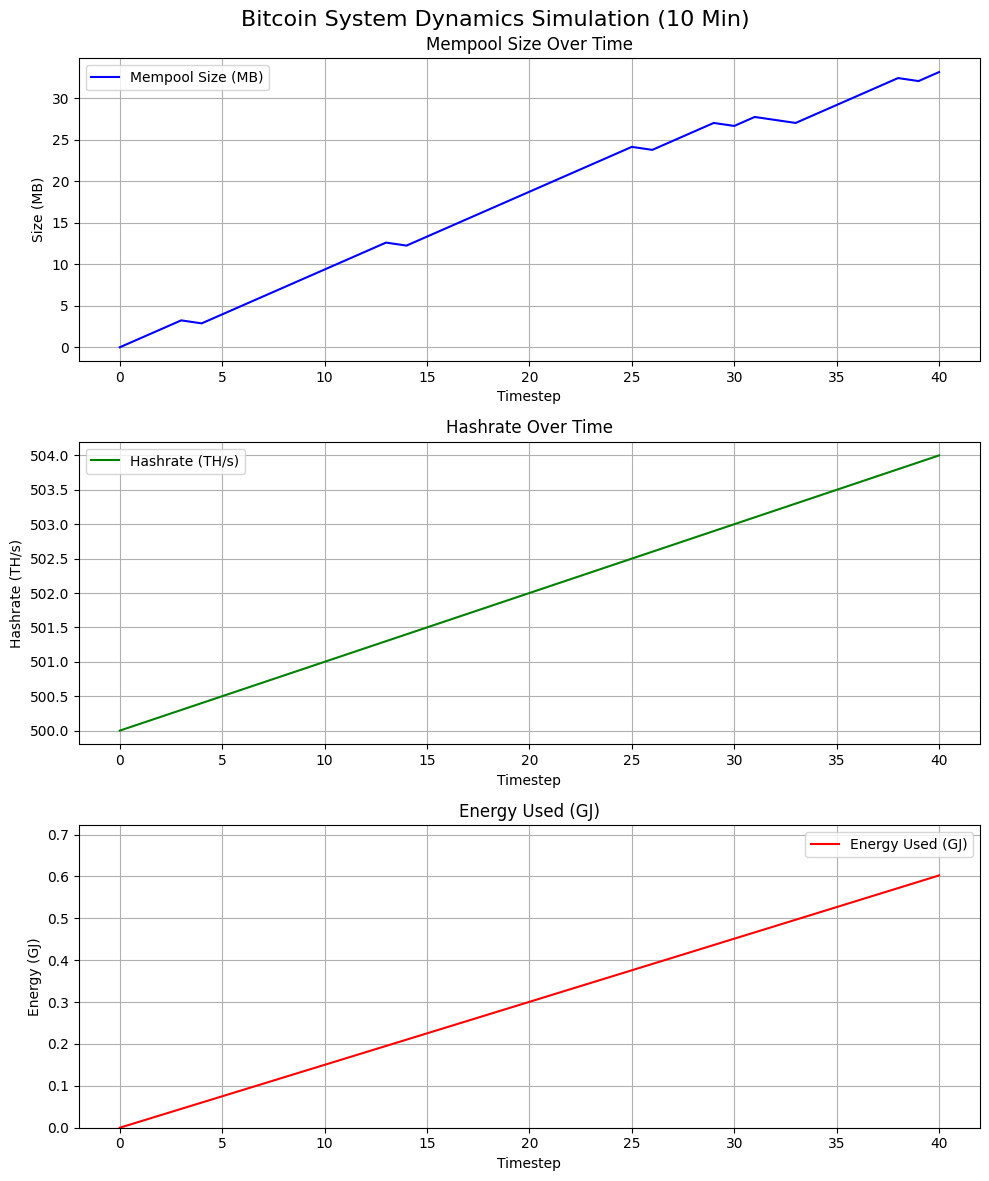

Total blocks produced: 0.47
Total transactions processed: 933.33
Transaction Throughput: 5600.00 tx/hour
Final Mempool Size: 33.12 MB
Final Hashrate: 504.00 TH/s
Energy Used: 0.60 GJ
Final Bitcoin Supply: 19750001.46 BTC


In [ ]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Initial State (Stocks) ---
initial_state = {
    'bitcoin_supply': 19750000,  # ~19.75M BTC in 2025 (post-2024 halving)
    'hashrate': 500,  # 500 TH/s (scaled for small network)
    'mempool_size': 0,  # MB of pending transactions
    'energy_used': 0,  # GJ
    'difficulty': 1.0  # Initial difficulty
}

# --- Parameters ---
params = {
    'block_reward': 3.125,  # Post-2024 halving reward
    'block_time_target': 600,  # 10 minutes in seconds
    'tx_per_block': 2000,  # Average transactions per block (from ABM)
    'avg_tx_size': 720,  # Average transaction size in bytes (Trader type from ABM)
    'energy_per_hash': 2e-6,  # Matches ~0.6 GJ over 10 min
    'tx_request_rate': 100  # 1500 tx/timestep
}

# --- State Update Functions ---
def update_bitcoin_supply(params, step, sL, s, _input):
    supply = s['bitcoin_supply']
    block_production_rate = _input.get('block_production_rate', 0)
    new_supply = supply + params['block_reward'] * block_production_rate
    return ('bitcoin_supply', new_supply)

def update_hashrate(params, step, sL, s, _input):
    hashrate = s['hashrate']
    hashrate_growth = 0.1  # Constant growth
    new_hashrate = hashrate + hashrate_growth
    return ('hashrate', max(new_hashrate, 0))

def update_mempool_size(params, step, sL, s, _input):
    mempool_size = s['mempool_size']
    tx_request_rate = _input.get('tx_request_rate', 0)
    tx_confirmation_rate = _input.get('tx_confirmation_rate', 0)
    mempool_change = (tx_request_rate - tx_confirmation_rate) * params['avg_tx_size'] / 1e6
    new_mempool_size = max(mempool_size + mempool_change, 0)
    return ('mempool_size', new_mempool_size)

def update_energy_used(params, step, sL, s, _input):
    energy = s['energy_used']
    hashrate = s['hashrate']
    energy_increment = (hashrate * 1e9) * params['energy_per_hash'] * 15 / 1e9  # GJ
    return ('energy_used', energy + energy_increment)

def update_difficulty(params, step, sL, s, _input):
    difficulty = s['difficulty']
    hashrate = s['hashrate']
    block_time = (step + 1) * 15  # Total elapsed time in seconds
    target_block_time = params['block_time_target']
    adjustment_factor = block_time / target_block_time if block_time > 0 else 1
    new_difficulty = difficulty * adjustment_factor
    return ('difficulty', max(new_difficulty, 1.0))

# --- Policy Functions ---
def network_policy(params, step, sL, s):
    hashrate = s['hashrate']
    difficulty = s['difficulty']
    # Adjust denominator to target ~1 block in 40 timesteps, add stochasticity
    block_chance = hashrate / (difficulty * 2000)  # ~0.25 chance per timestep
    block_produced = 1 if np.random.random() < block_chance else 0
    block_production_rate = block_produced / 15  # Per second (15-second timestep)

    tx_request_rate = params['tx_request_rate'] * 15
    tx_confirmation_rate = params['tx_per_block'] * block_production_rate * 15

    return {
        'block_production_rate': float(block_production_rate),
        'tx_request_rate': float(tx_request_rate),
        'tx_confirmation_rate': float(tx_confirmation_rate)
    }

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {
        'policies': {'p1': network_policy},
        'variables': {
            'bitcoin_supply': update_bitcoin_supply,
            'hashrate': update_hashrate,
            'mempool_size': update_mempool_size,
            'energy_used': update_energy_used,
            'difficulty': update_difficulty
        }
    }
]

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),  # 40 steps = 10 minutes (15 seconds/step)
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep']
bitcoin_supply = final_substep['bitcoin_supply']
hashrate = final_substep['hashrate']
mempool_size = final_substep['mempool_size']
energy_used = final_substep['energy_used']

# Create plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Bitcoin System Dynamics Simulation (10 Min)', fontsize=16)

ax1.plot(timesteps, mempool_size, 'b-', label="Mempool Size (MB)")
ax2.plot(timesteps, hashrate, 'g-', label="Hashrate (TH/s)")
ax3.plot(timesteps, energy_used, 'r-', label="Energy Used (GJ)")

ax1.set_title("Mempool Size Over Time")
ax2.set_title("Hashrate Over Time")
ax3.set_title("Energy Used (GJ)")
ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Size (MB)")
ax2.set_ylabel("Hashrate (TH/s)")
ax3.set_ylabel("Energy (GJ)")
ax3.set_ylim(0, max(energy_used) * 1.2)
ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

plt.tight_layout()
plt.show()

# --- Metrics ---
total_blocks = (final_substep['bitcoin_supply'].iloc[-1] - final_substep['bitcoin_supply'].iloc[0]) / params['block_reward']
total_tx = total_blocks * params['tx_per_block']
simulation_time_hours = 40 * 15 / 3600
throughput = total_tx / simulation_time_hours if simulation_time_hours > 0 else 0

print(f"Total blocks produced: {total_blocks:.2f}")
print(f"Total transactions processed: {total_tx:.2f}")
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_size.iloc[-1]:.2f} MB")
print(f"Final Hashrate: {hashrate.iloc[-1]:.2f} TH/s")
print(f"Energy Used: {energy_used.iloc[-1]:.2f} GJ")
print(f"Final Bitcoin Supply: {bitcoin_supply.iloc[-1]:.2f} BTC")